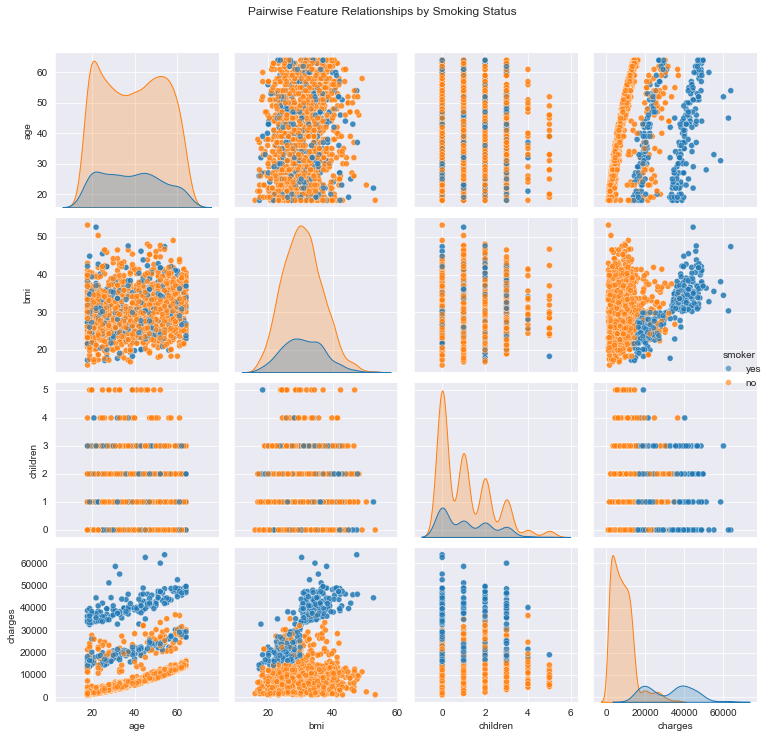

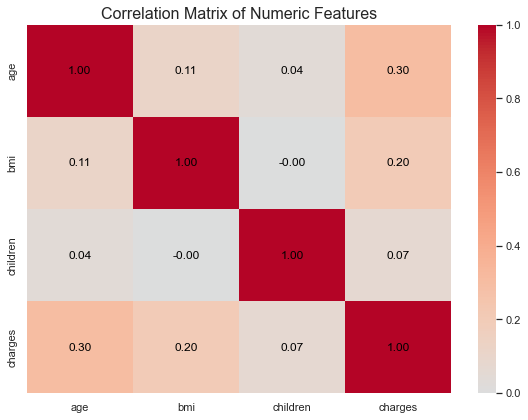

In [3]:
# 1 ▸ Imports: load all the libraries we’ll need
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib, warnings, json, pathlib

# suppress harmless warnings to keep output clean
warnings.filterwarnings("ignore")

# 2 ▸ Load data from CSV into a DataFrame
df = pd.read_csv("medical_insurance.csv")   # same CSV Saeed uses
# separate our target variable ("charges") from features
target = "charges"
y = df[target]
X = df.drop(columns=[target])

# 3 ▸ Quick EDA  (plots)

# Use a darker grid so text/population shows up
sns.set_style("darkgrid")

# Draw pairwise plots, semi‑transparent points
pair = sns.pairplot(df, hue="smoker", plot_kws={"alpha":0.6})

# Add a super‑title above the subplots
pair.fig.suptitle("Pairwise Feature Relationships by Smoking Status", y=1.02)

plt.tight_layout()
plt.show()


# Clean white background
sns.set(style="white")

# Compute correlations
corr = df.corr(numeric_only=True)

# Make the figure larger
plt.figure(figsize=(8,6))

# Plot with a diverging cmap and black text for annotations
sns.heatmap(
    corr,
    annot=True,            # show the numbers
    fmt=".2f",             # two decimals
    cmap="coolwarm",       # blue‑white‑red
    center=0,              # zero correlation is white
    annot_kws={"size":12, "color":"black"}
)

plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()



Linear    CV-RMSE = 6,073
Ridge     CV-RMSE = 6,073
Lasso     CV-RMSE = 6,073
RF        CV-RMSE = 1,823
GBR       CV-RMSE = 3,550


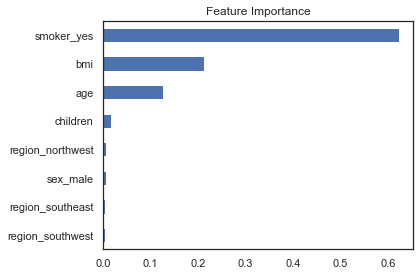


► Leaderboard
  RF      : 1,823
  GBR     : 3,550
  Lasso   : 6,073
  Linear  : 6,073
  Ridge   : 6,073

Best model saved to model/medical_cost.pkl  (RMSE ≈ 1,823)


In [4]:

# 4 ▸ Preprocessing: define which columns to scale vs encode
cat_cols = ["sex", "smoker", "region"]  # categorical features
num_cols = ["age", "bmi", "children"]   # numeric features


# build a transformer that:
#  • scales numeric columns (StandardScaler)
#  • one-hot-encodes categorical columns, dropping the first level
pre = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(drop="first"), cat_cols)],
    remainder="passthrough"  # leave any other columns untouched
)


# 5 ▸ Model definitions & hyperparameter grids (Choose before training the models)
models = {
    "Linear":  (LinearRegression(),                  {}), # no hyperparams to search
    "Ridge":   (Ridge(),  {"model__alpha":[0.1,1,10]}),
    "Lasso":   (Lasso(),  {"model__alpha":[0.001,0.01,0.1]}),
    "RF":      (RandomForestRegressor(random_state=42),
                {"model__n_estimators":[200],
                 "model__max_depth":[None,8,12]}),
    "GBR":     (GradientBoostingRegressor(random_state=42),
                {"model__n_estimators":[300],
                 "model__learning_rate":[0.05,0.1]})
}

best_rmse, best_pipe = 1e9, None
results = []


# 6 ▸ Loop through each model, do CV or grid-search, record RMSE
for name, (estimator, grid) in models.items():

    # create a pipeline: preprocessing → model
    pipe = Pipeline([("pre", pre), ("model", estimator)])
    if grid:
        # grid-search over hyperparameters with 5‑fold CV
        grid = {k: v for k, v in grid.items()}  # avoid mutability bugs
        gs   = GridSearchCV(pipe, grid, cv=5, scoring="neg_root_mean_squared_error")
        gs.fit(X, y)
        rmse = -gs.best_score_   # convert negative RMSE to positive
        model = gs.best_estimator_
    else:
         # no grid: just cross-validate default pipeline
        scores = cross_val_score(pipe, X, y,
                                 cv=5, scoring="neg_root_mean_squared_error")
        rmse = -scores.mean()
        model = pipe.fit(X, y)
    results.append((name, rmse))

      # keep track of the best-performing pipeline
    if rmse < best_rmse: best_rmse, best_pipe = rmse, model
    print(f"{name:8s}  CV-RMSE = {rmse:,.0f}")



# 7 ▸ Save the best pipeline to disk for later use in the app
pathlib.Path("model").mkdir(exist_ok=True)
joblib.dump(best_pipe, "model/medical_cost.pkl")


# 8 ▸ (Optional) Plot feature importances if the model supports it
if hasattr(best_pipe.named_steps["model"], "feature_importances_"):
    ohe = best_pipe.named_steps["pre"].named_transformers_["cat"]
    feat_names = (num_cols +
                  list(ohe.get_feature_names_out(cat_cols)))
    importances = best_pipe.named_steps["model"].feature_importances_
    imp = pd.Series(importances, index=feat_names).sort_values()
    imp.plot(kind="barh", figsize=(6,4), title="Feature Importance")
    plt.tight_layout()
    plt.show()


# 9 ▸ Summarize the leaderboard of all models
print("\n► Leaderboard")
for n, r in sorted(results, key=lambda x: x[1]):
    print(f"  {n:8s}: {r:,.0f}")
print(f"\nBest model saved to model/medical_cost.pkl  (RMSE ≈ {best_rmse:,.0f})")